### Import libraries

In [22]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import os
import re
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time
from sklearn.tree import DecisionTreeClassifier

### Data cleaning

In [23]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

[nltk_data] Downloading package punkt to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Wei
[nltk_data]     Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Wei Ling\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [24]:
# Load data
books_df = pd.read_csv('Book_data.csv')

In [25]:
print(books_df.shape)

(21212, 2)


In [26]:
# Check that sentimt is of integer
books_df.dtypes

comment_text    object
sentiment        int64
dtype: object

In [27]:
comment_df = books_df[['comment_text', 'sentiment']]

In [28]:
comment_df.head()

,comment_text,sentiment
0,started reading catch22 but year read consider...,1
1,way dune written might favorite canticle leibo...,1
2,talked school year ago told class creation hid...,2
3,here thought reading first twothis series defi...,1
4,liked exactly dislikedthats would probably pre...,2


In [29]:
# drop 2 and 3
comment_df = comment_df[comment_df.sentiment != 2]
comment_df = comment_df[comment_df.sentiment != 3]
comment_df['sentiment'].unique()

array([1, 0], dtype=int64)

In [30]:
print(comment_df.shape)

(18135, 2)


In [31]:
def data_cleaning(x):
    x = str(x)
    pattern = '[^a-zA-Z0-9\ ]'
    x = re.sub(pattern,'',x)
    x = x.lower()
    x = x.strip()
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    x = re.sub(r'(.)\1+', r'\1\1', x)
    # Remove - & '
    x = re.sub(r'(-|\')', ' ', x)
    return x

In [32]:
def remove_links_funny_words(x):
    x = re.sub('(https?://[\S]+)', ' URL ', str(x))
    x = x.replace("xmass", "christmas")
    x = x.replace("...", " ")
    x = x.replace("'ll", "will")
    x = x.replace("tewwible", "terrible")
    x = x.replace("frekking", "freaking")
    return x

In [33]:
comment_df = comment_df[comment_df['comment_text'] != '']
comment_df['comment_text'] = comment_df['comment_text'].apply(remove_links_funny_words).apply(data_cleaning)
comment_df.head()

,comment_text,sentiment
0,started reading catch22 but year read consider...,1
1,way dune written might favorite canticle leibo...,1
3,here thought reading first twothis series defi...,1
5,one favourite lsi think everything scifi setti...,1
6,never loved read beyond elementary school slow...,1


In [34]:
# deal with empty values
comment_df['comment_text'] = comment_df['comment_text'].fillna('').apply(str)
comment_df.head()

,comment_text,sentiment
0,started reading catch22 but year read consider...,1
1,way dune written might favorite canticle leibo...,1
3,here thought reading first twothis series defi...,1
5,one favourite lsi think everything scifi setti...,1
6,never loved read beyond elementary school slow...,1


In [35]:
# Stemming
def word_pre(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    store = ''

    for i in x:
        store += stemmer.stem(i) + ' '

    return store

# Stopwords
stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d"]
stop = set(stop + additional_stopwords)
def remove_stop(x):
    x = word_tokenize(x)
    store = ''

    for i in x:
        if i not in stop:
            store += i + ' '

    return store

def lemmatize(text):
  store = ''
  tokens = word_tokenize(text)
  lemma_function = WordNetLemmatizer()
  for token, tag in pos_tag(tokens):
    store += lemma_function.lemmatize(token, tag_map[tag[0]]) + ' '
  return str(store)

In [36]:
comment_df['comment_cleaned'] = comment_df['comment_text'].apply(remove_stop)

### Split data

In [37]:
x_train, x_test, y_train, y_test = train_test_split(comment_df[['comment_cleaned']],
                                                    comment_df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=0)

In [38]:
vectorizer = CountVectorizer(ngram_range=(1,2))
comment_matrix = vectorizer.fit_transform(x_train['comment_cleaned'])

### Decision Tree

In [39]:
decision_tree=DecisionTreeClassifier(criterion='gini',splitter='best',max_features='sqrt')
comment_classifier = decision_tree.fit(comment_matrix, y_train)

test_vector = vectorizer.transform(x_test['comment_cleaned'])
result = comment_classifier.predict(test_vector)
confuse = metrics.confusion_matrix(y_test, result)
confuse

array([[ 768,  473],
       [ 346, 2040]], dtype=int64)

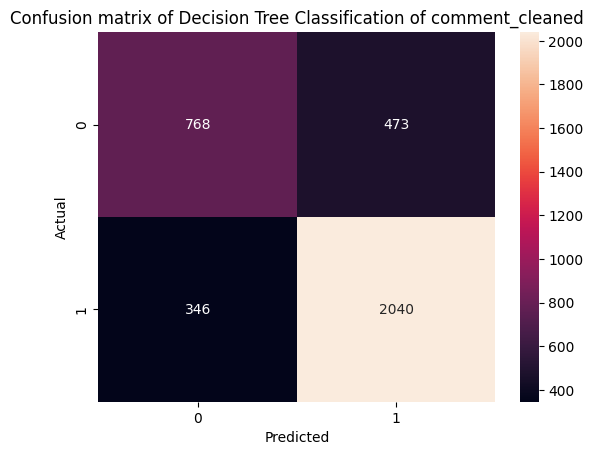

In [40]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of comment_cleaned")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
dt_F1_score = metrics.f1_score(y_test, result)
dt_average_precision = metrics.average_precision_score(y_test, result)
dt_precision_score= metrics.precision_score(y_test, result)
dt_recall_score = metrics.recall_score(y_test, result)
dt_accuracy = metrics.accuracy_score(y_test, result)

print('F1 score: {0:0.3f}'.format(dt_F1_score))
print('Precision score: {0:0.3f}'.format(dt_precision_score))
print('Recall score: {0:0.3f}'.format(dt_recall_score))
print('Average precision-recall score: {0:0.3f}'.format(dt_average_precision))
print('Accuracy score: {0:0.3f}'.format(dt_accuracy))

F1 score: 0.833
Precision score: 0.812
Recall score: 0.855
Average precision-recall score: 0.789
Accuracy score: 0.774


### Enhanced Decision Tree - Grid Search

In [42]:
param_grid = { 
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features': ['auto','sqrt','log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv= 3)
grid_search.fit(test_vector, y_test)
grid_search.best_params_

C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

{'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'random'}

### Enhanced Decision Tree - Grid Search [3-folds]

In [43]:
param_grid = { 
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features': ['auto','sqrt','log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv= 3)
grid_search.fit(test_vector, y_test)
grid_search.best_params_

C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

{'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}

In [44]:
decision_tree=DecisionTreeClassifier(criterion='entropy',splitter='best',max_features='sqrt')
comment_classifier = decision_tree.fit(comment_matrix, y_train)

test_vector = vectorizer.transform(x_test['comment_cleaned'])
result = comment_classifier.predict(test_vector)
confuse = metrics.confusion_matrix(y_test, result)
confuse

array([[ 759,  482],
       [ 300, 2086]], dtype=int64)

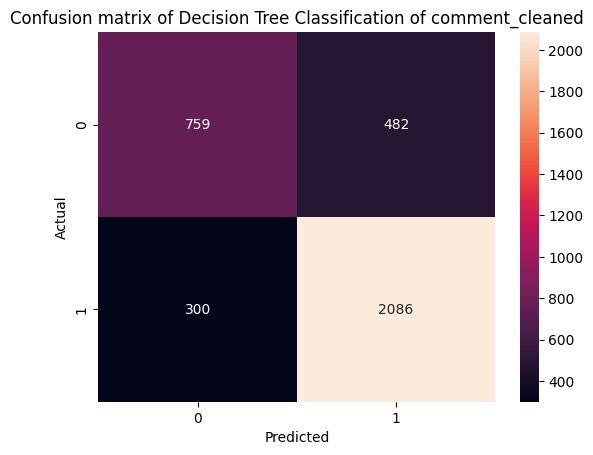

In [45]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of comment_cleaned")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [46]:
dt_3fold_F1_score = metrics.f1_score(y_test, result)
dt_3fold_average_precision = metrics.average_precision_score(y_test, result)
dt_3fold_precision_score= metrics.precision_score(y_test, result)
dt_3fold_recall_score = metrics.recall_score(y_test, result)
dt_3fold_accuracy = metrics.accuracy_score(y_test, result)

print('F1 score: {0:0.3f}'.format(dt_3fold_F1_score))
print('Precision score: {0:0.3f}'.format(dt_3fold_precision_score))
print('Recall score: {0:0.3f}'.format(dt_3fold_recall_score))
print('Average precision-recall score: {0:0.3f}'.format(dt_3fold_average_precision))
print('Accuracy score: {0:0.3f}'.format(dt_3fold_accuracy))

F1 score: 0.842
Precision score: 0.812
Recall score: 0.874
Average precision-recall score: 0.793
Accuracy score: 0.784


### Enhanced Decision Tree - Grid Search [5-folds]

In [47]:
param_grid = { 
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_features': ['auto','sqrt','log2']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv= 5)
grid_search.fit(test_vector, y_test)
grid_search.best_params_

C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Wei Ling\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

{'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'random'}

In [48]:
decision_tree=DecisionTreeClassifier(criterion='entropy',splitter='random',max_features='sqrt')
comment_classifier = decision_tree.fit(comment_matrix, y_train)

test_vector = vectorizer.transform(x_test['comment_cleaned'])
result = comment_classifier.predict(test_vector)
confuse = metrics.confusion_matrix(y_test, result)
confuse

array([[ 816,  425],
       [ 300, 2086]], dtype=int64)

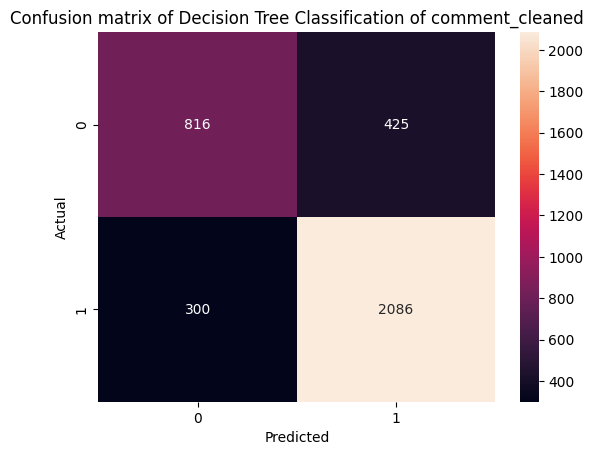

In [49]:
fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of comment_cleaned")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
dt_5fold_F1_score = metrics.f1_score(y_test, result)
dt_5fold_average_precision = metrics.average_precision_score(y_test, result)
dt_5fold_precision_score= metrics.precision_score(y_test, result)
dt_5fold_recall_score = metrics.recall_score(y_test, result)
dt_5fold_accuracy = metrics.accuracy_score(y_test, result)

print('F1 score: {0:0.3f}'.format(dt_5fold_F1_score))
print('Precision score: {0:0.3f}'.format(dt_5fold_precision_score))
print('Recall score: {0:0.3f}'.format(dt_5fold_recall_score))
print('Average precision-recall score: {0:0.3f}'.format(dt_5fold_average_precision))
print('Accuracy score: {0:0.3f}'.format(dt_5fold_accuracy))

F1 score: 0.852
Precision score: 0.831
Recall score: 0.874
Average precision-recall score: 0.809
Accuracy score: 0.800


### Evaluation

In [51]:
print("Decison Tree")
print('Accuracy score: {0:0.3f}'.format(dt_accuracy))
print()
print("Decision Tree - Grid Search - 3-folds")
print('Accuracy score: {0:0.3f}'.format(dt_3fold_accuracy))
print()
print("DEcision Tree - Grid Search - 5-folds")
print('Accuracy score: {0:0.3f}'.format(dt_5fold_accuracy))

Decison Tree
Accuracy score: 0.774

Decision Tree - Grid Search - 3-folds
Accuracy score: 0.784

DEcision Tree - Grid Search - 5-folds
Accuracy score: 0.800
